In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# Load and preprocess data
df = pd.read_csv('med_events_ATC.csv')
df = df[['PATIENT_ID', 'DATE', 'PERDAY', 'CATEGORY', 'DURATION']]
df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
df['eksd'] = pd.to_datetime(df['eksd'])

def See(arg1):
    # Filter by ATC
    C09CA01 = df[df['ATC'] == arg1].copy()
    
    # Process event intervals
    Drug_see_p1 = C09CA01.sort_values(['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per patient
    Drug_see_p1 = Drug_see_p1.groupby('pnr').sample(n=1, random_state=1)
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    
    # ECDF processing
    x = np.sort(Drug_see_p1['event_interval'])
    y = np.arange(1, len(x)+1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    dfper = dfper[dfper['y'] <= 0.8]
    if dfper.empty:
        return C09CA01.assign(Median=np.nan, Cluster=np.nan)
    ni = dfper['x'].max()
    
    # Silhouette analysis
    X = dfper[['x']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    max_cluster = 2
    best_score = -1
    for k in range(2, min(11, len(X_scaled))):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(X_scaled)
        if len(np.unique(labels)) < 2:
            continue
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            max_cluster = k
    
    # K-means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Calculate cluster stats
    cluster_stats = dfper.groupby('cluster')['x'].agg(
        amin_log=lambda x: np.log(x).min(),
        amax_log=lambda x: np.log(x).max(),
        amedian_log=lambda x: np.log(x).median()
    ).reset_index()
    cluster_stats['amin'] = np.exp(cluster_stats['amin_log'])
    cluster_stats['amax'] = np.exp(cluster_stats['amax_log'])
    cluster_stats['amedian'] = np.exp(cluster_stats['amedian_log'])
    
    # Cross join and merge results
    Drug_see_p1['key'] = 1
    cluster_stats['key'] = 1
    results = pd.merge(Drug_see_p1, cluster_stats, on='key')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['amin']) & 
        (results['event_interval'] <= results['amax']),
        results['cluster'],
        np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    
    if not results.empty:
        t1 = results['cluster'].value_counts().index[0]
        median_value = cluster_stats.loc[cluster_stats['cluster'] == t1, 'amedian'].values[0]
    else:
        median_value = np.nan
        t1 = np.nan
    
    # Merge back to original data
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p0['Median'] = median_value
    Drug_see_p0['Cluster'] = t1
    return Drug_see_p0

def see_assumption(arg1):
    arg1 = arg1.sort_values(['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    arg1['p_number'] = arg1.groupby('pnr').cumcount() + 1
    
    Drug_see2 = arg1[arg1['p_number'] >= 2].copy()
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    
    medians = Drug_see2.groupby('pnr')['Duration'].median().median()
    plt.axhline(medians, color='r', linestyle='--')
    plt.title('Boxplot of Duration by Prescription Number')
    plt.show()


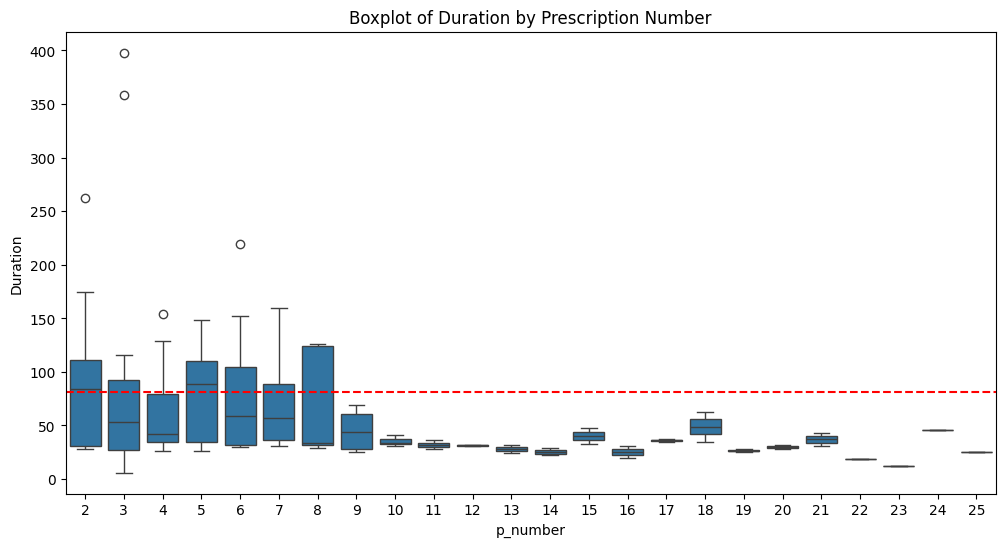

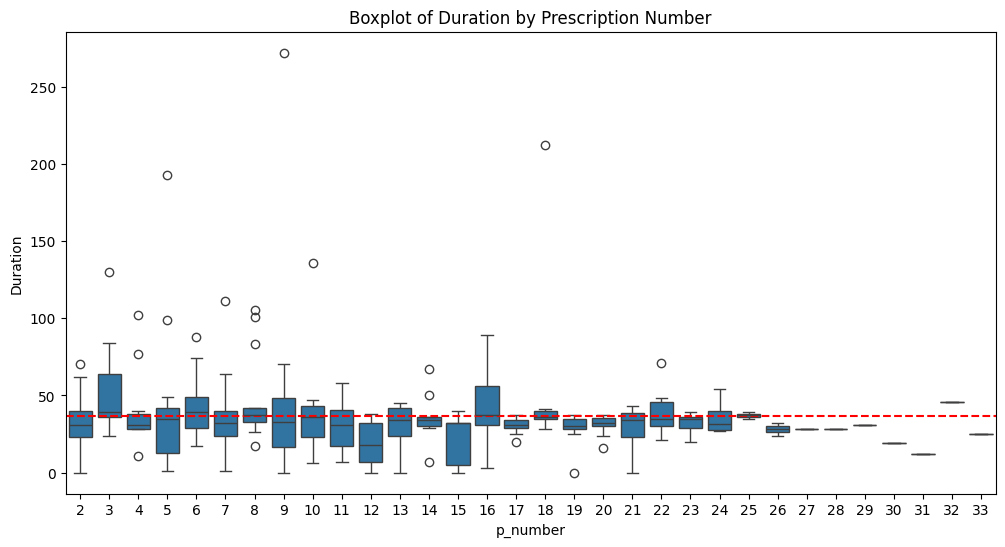

In [ ]:
medA = See("A11CC05")
medB = See("A09AA02")

see_assumption(medA)
see_assumption(medB)